#### Comments on code quality: pd.DataFrame.copy() is frequently used in cells, this is to avoid the need to rerun cells, as some took upwards of 30 minutes on my machine. Ideally those wouldnt be there for optimal code

## Imports for project

In [28]:
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## Import data from csv

In [29]:
data = pd.read_csv('all_stocks_5yr.csv')

## Data Encoding

In [30]:
#cut off year
data['date'] = data['date'].astype(str).str[:-5]
#Encode data for Date and Name
le = preprocessing.LabelEncoder()
#print(data.sort_values(["date"]))
data["date"] = le.fit_transform(data["date"])
data["Name"] = le.fit_transform(data["Name"])
#print(data.sort_values(["date"]))



## Cluster Data on dates

In [32]:
cdata = data.copy()
dates = list(range(0,363))
first2 = True
#col = ['date','open','high','low','close','volume','Name']
#dates2 = pd.DataFrame(columns=col)
#loop through all unique days present
for day in dates:
    #loop though and compare for all matching days and add to list
    first = True
    for i in range(cdata.__len__()):
        if cdata.iloc[i,0] == day:
            if first == True:
                #print(pd.DataFrame(cdata.iloc[[i]]))
                dates2 = pd.DataFrame(cdata.iloc[[i]])
                #print(dates2)
                first = False
            else:    
                dates2 = dates2.append(pd.DataFrame(cdata.iloc[[i]]))
    #take mean of list
    if first2 == True:
        series = dates2.mean(axis=0)
        df = pd.DataFrame(series).transpose()
        average = pd.DataFrame(df)
        first2 = False
    else:
        series = dates2.mean(axis=0)
        df = pd.DataFrame(series).transpose()
        average = average.append(pd.DataFrame(df))

## Create DF of averages

In [172]:
means = average.copy()

## Calculate 5 year avg of S&P500 and standard deviation of each column

In [322]:
std = means.copy()
std = std.drop(['date', 'volume','Name'], axis=1)
std = std.std()
std = pd.DataFrame(std).transpose()

avg = means.copy()

avg = avg.drop(['date', 'volume','Name'], axis=1)
avg = avg.mean(axis=0)
avg = pd.DataFrame(avg).transpose()

## Create response DF

In [323]:
response = means.copy()
response = response.drop(['date', 'volume','Name'], axis=1)
response.reset_index(inplace=True)
response = response.drop(['index'],axis=1)
actions = []

for index, row in response.iterrows():
    if row['open'] < avg.iloc[0]['open']-.5*std.iloc[0]['open'] and row['high'] < avg.iloc[0]['high']-.5*std.iloc[0]['high'] and row['low'] < avg.iloc[0]['low']-.5*std.iloc[0]['low'] and row['close'] < avg.iloc[0]['close']-.5*std.iloc[0]['close']:
        actions.append("buy")
    elif row['open'] > avg.iloc[0]['open']+.5*std.iloc[0]['open'] and row['high'] > avg.iloc[0]['high']+.5*std.iloc[0]['high'] and row['low'] > avg.iloc[0]['low']+.5*std.iloc[0]['low'] and row['close'] > avg.iloc[0]['close']+.5*std.iloc[0]['close']:
        actions.append("sell")
    else:
        actions.append("pass")
response['actions'] = actions

## Data Normalization (implemented here but unused as it deteriorated performance)

In [324]:
normData = response.copy()
normData = normData.drop(["actions"],axis=1)
normData = pd.DataFrame(preprocessing.normalize(normData,norm="l2"))
normData['actions'] = actions
normData.columns = ['open', 'high','low','close','actions']

## Split Dataset

In [325]:
trainingset = response.copy()#Visible here the response DF which not normalized is used here

training = pd.DataFrame(trainingset.sample(frac=0.8,replace=False))
test = pd.DataFrame(pd.concat([trainingset,training]).drop_duplicates(keep=False))

## Logistic Regression

In [326]:
logReg = LogisticRegression()
logReg.fit(training[['open','high','low','close']],training['actions'])
pred = logReg.predict(test[['open','high','low','close']])
cf_matrix = confusion_matrix(test['actions'], pred)

## Validate Output

In [327]:
logReg.score(test[['open','high','low','close']],test['actions'])

0.87671232876712324

## Vizualization

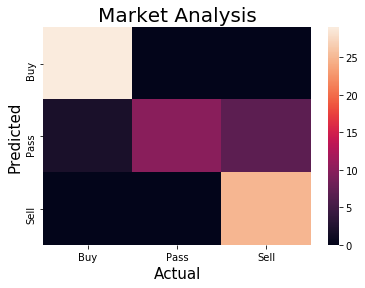

In [328]:
x_axis_labels = ['Buy','Pass','Sell'] # labels for x-axis
y_axis_labels = ['Buy','Pass','Sell'] # labels for y-axis
# create seaborn heatmap with required labels
sns.heatmap(cf_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title('Market Analysis', fontsize = 20)
plt.ylabel('Predicted', fontsize = 15) 
plt.xlabel('Actual', fontsize = 15) 
plt.show()